#### **Approved drugs from the ChEMBL database**

Inspired by: youtube.com/c/DataProfessor

**Import libraries**

In [1]:
import matplotlib.pyplot as plt
import mols2grid
import numpy as np
import pandas as pd
from chembl_webresource_client.new_client import new_client
from IPython.display import display, Image
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Descriptors import ExactMolWt

**See available data entities**

In [2]:
available_resources = [resource for resource in dir(new_client) if not resource.startswith("_")]
print(available_resources)

['activity', 'activity_supplementary_data_by_activity', 'assay', 'assay_class', 'atc_class', 'binding_site', 'biotherapeutic', 'cell_line', 'chembl_id_lookup', 'compound_record', 'compound_structural_alert', 'description', 'document', 'document_similarity', 'drug', 'drug_indication', 'drug_warning', 'go_slim', 'image', 'mechanism', 'metabolism', 'molecule', 'molecule_form', 'official', 'organism', 'protein_class', 'similarity', 'source', 'substructure', 'target', 'target_component', 'target_relation', 'tissue', 'xref_source']


**Filter drugs by approval year**

In [3]:
# get all the drugs approved (phase IV) since 2000
start_year = 2000
clinical_phase = 4

molecule = new_client.molecule
by = "molecule_properties__mw_freebase"
res = molecule.filter(first_approval__gte=start_year,
                      max_phase=clinical_phase).order_by(by)
df = pd.DataFrame.from_dict(res)
df = df.sort_values(by="first_approval")
df.head()

,atc_classifications,availability_type,biotherapeutic,black_box_warning,chebi_par_id,chirality,cross_references,dosed_ingredient,first_approval,first_in_class,...,topical,usan_stem,usan_stem_definition,usan_substem,usan_year,withdrawn_class,withdrawn_country,withdrawn_flag,withdrawn_reason,withdrawn_year
295,[A07EC04],1,None,0,267413.0,2,"[{'xref_id': 'balsalazide%20disodium', 'xref_n...",False,2000,0,...,False,-sal-,anti-inflammatory agents (salicylic acid deriv...,-sal-,1994.0,None,None,False,None,NaN
469,"[G03XB01, G03XB51]",1,None,1,50692.0,1,"[{'xref_id': 'mifepristone', 'xref_name': 'mif...",True,2000,0,...,False,-pristone,progesterone receptor antagonists,-pristone,1998.0,None,None,False,None,NaN
846,[S01LA01],1,None,0,NaN,-1,"[{'xref_id': 'verteporfin', 'xref_name': 'vert...",True,2000,0,...,False,-porfin,benzoporphyrin derivatives,-porfin,1993.0,None,None,False,None,NaN
845,[H01CC02],1,"{'biocomponents': [], 'description': 'CETROREL...",0,59224.0,1,"[{'xref_id': 'cetrorelix', 'xref_name': 'cetro...",True,2000,0,...,False,-relix,hormone-release inhibiting peptides,-relix,2000.0,None,None,False,None,NaN
844,[],1,"{'biocomponents': [], 'description': 'CETROREL...",0,31387.0,1,[],True,2000,0,...,False,-relix,hormone-release inhibiting peptides,-relix,2000.0,None,None,False,None,NaN


**Count the approved drugs/biotherapeutics per year**

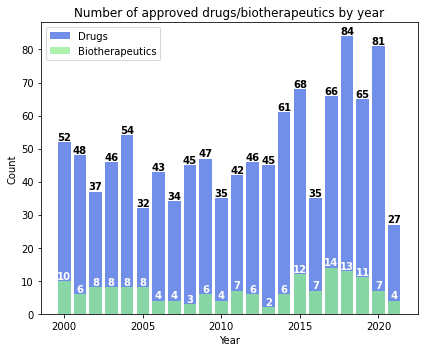

In [4]:
fig, ax = plt.subplots(figsize=(6,5))

drugs = df["first_approval"].value_counts(sort=False)
biotherapeutics = df[df["biotherapeutic"].notnull()]["first_approval"].value_counts(sort=False)

ax.bar(x=drugs.index, height=drugs.values, alpha=0.75, color="royalblue", label="Drugs")
ax.bar(x=biotherapeutics.index, height=biotherapeutics.values, alpha=0.75, color="lightgreen", label="Biotherapeutics")
ax.bar_label(ax.containers[0], color="k", fontweight="bold")
ax.bar_label(ax.containers[1], color="white", fontweight="bold")

ax.set_title("Number of approved drugs/biotherapeutics by year")
ax.set_xlabel("Year")
ax.set_ylabel("Count")

plt.legend()
fig.tight_layout()
plt.show()

**Utility functions**

In [5]:
def to_canonical_smile(x):
      """ Get canonical smile for molecule structures """
      return np.nan if pd.isna(x) else x["canonical_smiles"]

def to_name(x):
      """ Get name of the compound from molecule synonyms """
      return np.nan if not x else x[0]["molecule_synonym"]

def to_mw(x):
      """ Get molecular weight from smile """
      mol = Chem.MolFromSmiles(x)
      return round(ExactMolWt(mol), 2)

In [6]:
df["smiles"] = df["molecule_structures"].apply(to_canonical_smile)
df["name"] = df["molecule_synonyms"].apply(to_name)

**Approved drugs in 2020**

In [7]:
# First drop rows where no canonical smile or commercial name is available
df.dropna(subset=["smiles", "name"], inplace=True)

# select 2020 approved drugs
sel_year = 2020
df_2020 = df[["name", "smiles", "biotherapeutic"]][df["first_approval"] == sel_year]

**Get molecular weights**

In [8]:
df_2020["mw"] = df_2020["smiles"].apply(to_mw)
df_2020.head()

,name,smiles,biotherapeutic,mw
170,BAY 2502,CC1CS(=O)(=O)CCN1/N=C/c1ccc([N+](=O)[O-])o1,None,287.06
21,Calcium oxybate,O=C([O-])CCCO.O=C([O-])CCCO.[Ca+2],None,246.04
153,Cenobamate,NC(=O)O[C@@H](Cn1ncnn1)c1ccccc1Cl,None,267.05
140,18F-AV-1451,[18F]c1ccc(-c2ccc3c(c2)[nH]c2ccncc23)cn1,None,262.09
139,Flortaucipir,Fc1ccc(-c2ccc3c(c2)[nH]c2ccncc23)cn1,None,263.09


**Represent found molecules using mols2grid**

Highlight biotherapeutics

In [9]:
grid = mols2grid.MolGrid(df_2020, smiles_col="smiles",
                         name="Approved drugs in 2020",
                         use_coords=True,
                         fixedBondLength=25)

grid.display(subset=["img", "name", "mw"],
             tooltip=["name", "mw", "biotherapeutic"],
             style={"biotherapeutic": lambda x: "color: green; font-weight: bold;" if pd.notna(x) else "",
                    "__all__": lambda x: "background-color: honeydew;" if pd.notna(x["biotherapeutic"]) else ""
                    })

**For some reasons, mols2grid is not displayed on online notebooks**

So, display 2D depictions of a subset (9) of these molecules using the default RDKit function Draw.MolsToGridImage

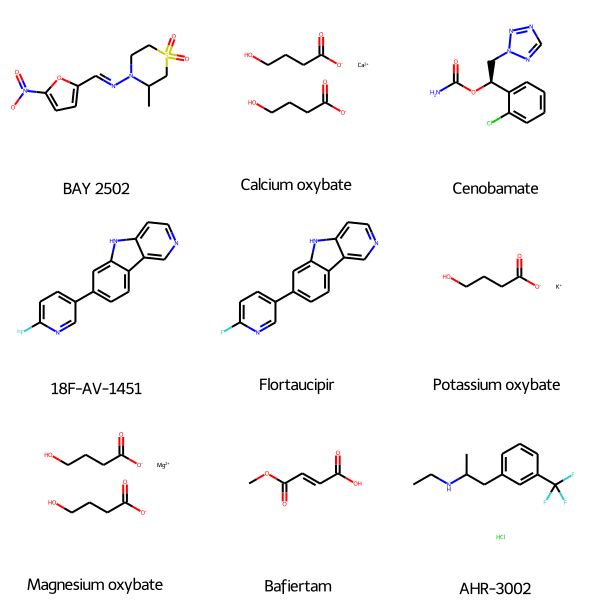

In [10]:
n_mols = 9

mols = df_2020["smiles"][:n_mols].apply(Chem.MolFromSmiles)
legend = [*df_2020["name"]][:n_mols]
mols.apply(AllChem.Compute2DCoords)

Draw.MolsToGridImage(mols, molsPerRow=3, legends=legend)